In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as plt

def Y_a_b(genes, a, b):
  return np.mean(genes[a:b])

def C_a_b(genes, a, b):
  mean = Y_a_b(genes, a, b+1)
  return sum( (np.array(genes[a:b+1]) - mean) ** 2 )

def determine_h(P, i, j, genes):
  N = len(genes)

  if (i == 0 and j > 0):
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, 0, P[i][j]);
  elif (i == j and j > 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, P[i-1][j], P[i][j]);
  elif (i == 0 and j == 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, 0, P[i][j]);
  else:
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, P[i-1][j], P[i][j]);

def BASC_A(gene):
    gene_og = gene
    gene = np.sort(gene)
    N = len(gene)

    cost_matrix = [[0 for _ in range(N - 1)] for _ in range(N)]
    ind_matrix = [[0 for _ in range(N - 2)] for _ in range(N - 1)]
    P = [[0 for _ in range(N - 2)] for _ in range(N - 2)]

    # Step 1: Compute a Series of Step Function

    # initialization C_i_(0) = c_i_N
    # calculate first cost matrix column with no intermidiate break points
    for i in range(N):
      cost_matrix[i][0] = C_a_b(gene, i, N)

    # Algorithm 1: Calculate optimal step functions
    for j in range(N-2):
      for i in range(N-j-1):
        min_value = math.inf
        min_index = math.inf

        for d in range(N-j-1):
          curr_value = C_a_b(gene, i, d) + cost_matrix[d+1][j]

          if(curr_value < min_value):
            min_value = curr_value
            min_index = d

        cost_matrix[i][j+1] = min_value
        ind_matrix[i][j] = min_index + 1

    #  Algorithm 2: Compute the break points of all optimal step functions
    for j in range(N-2):
      z = j
      P[0][j] = ind_matrix[0][z]
      if(j > 0):
        z = z - 1
        for i in range(1, j+1):
          P[i][j] = ind_matrix[P[i-1][j]][z]
          z = z - 1

    # Step 2: Find Strongest Discontinuity in Each Step Function
    v = [0] * (N-2)

    for j in range(N-2):
      max_value = -math.inf
      max_index = j
      for i in range(j+1):
        h = determine_h(P, i, j, gene)
        z = (gene[P[i][j]] + gene[P[i][j]-1]) / 2
        e = sum( (np.array(gene) - z) ** 2 )
        q_score = h / e
        if(q_score > max_value):
          max_value = q_score
          max_index = i

      v[j] = P[max_index][j]

    # Step 3: Estimate Location and Variation of the Strongest Discontinuities
    thr = (gene[round(np.median(v))-1] + gene[round(np.median(v))]) / 2

    return thr, P


In [2]:
from sklearn.cluster import KMeans

def K_Means(genes):
    data = np.array(genes).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data)
    c=kmeans.labels_
    genes = np.array(genes)
    groupOne = genes[c==1]
    groupZero = genes[c==0]
    
    thr1 = np.mean(groupOne)
    thr2 = np.mean(groupZero)
    
    thr = (thr1 + thr2) / 2

    return thr

In [3]:
def getSSTOT(x, n, xmean):
    m = 0
    for i in range(n):
        m = m + (x[i] - xmean)**2
    return m


def onestep(x):
    
    n = len(x)
    #step = 0
    xmean = np.mean(x)
    SSTOT = getSSTOT(x, n, xmean)
    
    SSEmin = SSTOT
    
    for i in range(n-1):
        leftMean = np.mean(x[0:i+1])
    
        rightMean = np.mean(x[i+1:n])
        
        SSE = 0
        
        for j in range(n):
            if j < i+1:
                SSE = SSE + (x[j] - leftMean)**2
            else:
                SSE = SSE + (x[j] - rightMean)**2
                    
        
        if SSEmin > SSE:
            SSEmin = SSE
            #print("1:",SSEmin1)
                
            t = (leftMean + rightMean)/2
    
    
    
    return t

In [4]:
def shmulevich(x):
    
    n = len(x)
    s = np.sort(x)
    d = np.empty(n)
    
    for i in range(n-2):
        d[i] = s[i+1] - s[i]
    
    t = (s[n-1] - s[0])/(n-1)
    
    mn = s[n-1]
    index = 0
    
    for i in range(n-1):
        if d[i] > t and d[i] < mn:
            mn = d[i]
            index = i
            
    z = s[index + 1]
   
    
    return z

[[1, 0, 0, 1, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 1], [0, 1, 0, 0, 0], [1, 0, 0, 1, 0]]
[{'10101': '00100'}, {'00010': '00000'}, {'01000': '10000'}, {'10001': '00100'}, {'00100': '00000'}]


/Users/mterrefortes/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mterrefortes/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mterrefortes/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mterrefortes/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

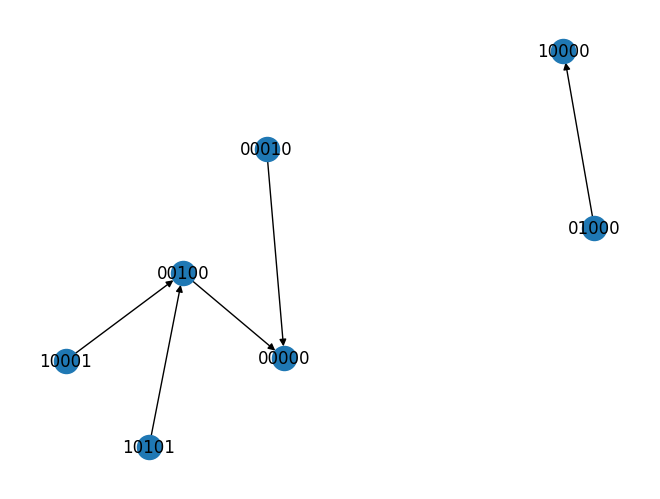

In [20]:
import networkx as nx

gene_data = pd.read_csv('tseriestest.txt', header=None)

def A(state):
    return state[1]

def B(state):
    return int(not state[0])

def C(state):
    return int(state[0] or state[1])

def D(state):
    return int(state[2] and (not state[4]))

def F(state):
    return int(not state[2])

def generate_network(genes, rules, method):
    
    binarize_arr = []
    
    binarized = []
    
    if(method == 'K-Means'):
        for i in genes:
            row = gene_data.iloc[i].values
            thr = K_Means(row)
            
            for j in range(len(row)):
                if(row[j] <= thr):
                    binarized.append(0)
                else:
                    binarized.append(1)
            binarize_arr.append(binarized)
            binarized = []
            
    
    elif(method == 'BASC A'):
        for i in genes:
            row = gene_data.iloc[i].values
            thr, _ = BASC_A(row)
            
            for j in range(len(row)):
                if(row[j] <= thr):
                    binarized.append(0)
                else:
                    binarized.append(1)
            binarize_arr.append(binarized)
            binarized = []
    
    elif(method == 'Onestep'):
        for i in genes:
            row = gene_data.iloc[i].values
            thr = onestep(row)
            
            for j in range(len(row)):
                if(row[j] <= thr):
                    binarized.append(0)
                else:
                    binarized.append(1)
            binarize_arr.append(binarized)
            binarized = []
        
    elif(method == 'Shmulevich'):
        for i in genes:
            row = gene_data.iloc[i].values
            thr = shmulevich(row)
            
            for j in range(len(row)):
                if(row[j] <= thr):
                    binarized.append(0)
                else:
                    binarized.append(1)
            binarize_arr.append(binarized)
            binarized = []
            
    
    print(binarize_arr)
    
    n = len(binarize_arr)
    m = len(binarize_arr[0])
    
    after_state = []
    
    
    for j in range(m):
        
        x = binarize_arr[0][j]
        y = binarize_arr[1][j]
        z = binarize_arr[2][j]
        d = binarize_arr[3][j]
        f = binarize_arr[4][j]
        
        xyz = str(''.join(map(str,[x,y,z, d, f])))
        
        A_ = A(xyz)
        B_ = B(xyz)
        C_ = C(xyz)
        D_ = D(xyz)
        F_ = F(xyz)
        
        ABC = str(''.join(map(str,[A_,B_,C_, D_, F_])))
        
        after_state.append({xyz:ABC})
        
    print(after_state)
    
    G = nx.DiGraph()
    
    for element in after_state:
        key = list(element.items())[0][0]
        value = list(element.items())[0][1]
        #print(key, value)
        
        G.add_edge(key, value)
    
    
    nx.draw(G, with_labels = True)

#selected = {'A': 1, 'B': 5, 'C': 9}
selected = [1, 4, 9, 11, 13]

generate_network(selected, 0, 'K-Means')

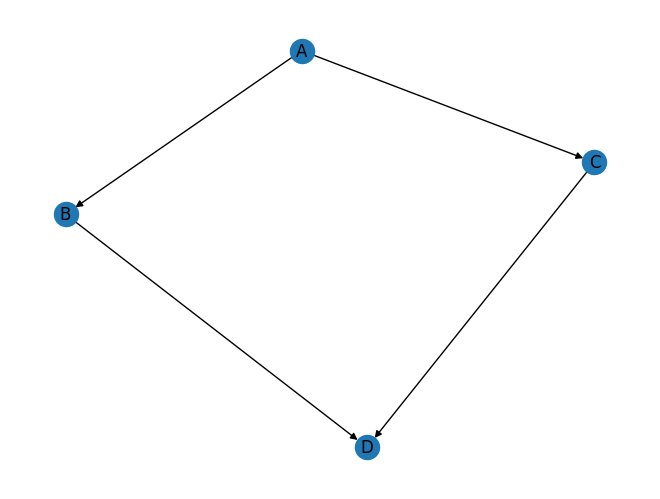

In [10]:
import networkx as nx
G = nx.DiGraph()
G.add_edge("A", "B")
G.add_edge("B", "D", weight=1)
G.add_edge("A", "C", weight=1)
G.add_edge("C", "D", weight=1)
nx.shortest_path(G, "A", "D", weight="weight")

nx.draw(G, with_labels = True)

In [11]:
import numpy as np
import matplotlib.pyplot as plt 

# Import the MarkovChain class from markovchain.py
from markovchain import MarkovChain

P = np.array([[0.8, 0.2], [0.1, 0.9]]) # Transition matrix
mc = MarkovChain(P, ['1', '2'])
mc.draw()

ImportError: cannot import name 'MarkovChain' from 'markovchain' (/Users/mterrefortes/miniconda3/lib/python3.10/site-packages/markovchain/__init__.py)

In [ ]:
a = [{1:2}, {3:4}]

In [ ]:
list(a[0].items())